##Final : Model Performance in Seismology

In [ ]:
# useful imports
import numpy as np
import csv
from pandas import *
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy.stats import kde
import math
import statistics
from matplotlib import colors
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Read in Datasets

Training, testing, and results:

*train* is the data UNet was trained on, and *test* is the data it was evaluated against. (Qualification: UNet did not explicitly use data from these files. Instead, it used raw waveforms *summarized* by these files. *train* and *test* are for human usability, whereas UNet utilizes raw waveforms). *resid* is the output of UNet, and describes its predictions. These three datasets are in csv file formats, so I'll use read_csv to read them in.

In [ ]:
train_file = "drive/MyDrive/Spring2023/DS2500/FinalData/train_data.csv"
train = read_csv(train_file)

test_file = "drive/MyDrive/Spring2023/DS2500/FinalData/test_data.csv"
test = read_csv(test_file)

resid_file = "drive/MyDrive/Spring2023/DS2500/FinalData/unet_residuals.csv"
resid = read_csv(resid_file)

Raw waveform data:

*waveform* is the data UNet analyzes. These are the raw waveforms that relevant features (amplitude, magnitude, depth, etc) are extracted from. Seismologists have taken these waveforms and created the catalog where *train* and *test* originate, but the residuals output by UNet correspond to specific raw waveforms only accessible by index. These exist in an h5 file which cannot be easily used to join *resid* with *train* or *test.*

Even so, I'll read it in here using h5py.

In [ ]:
waveformData = h5py.File("drive/MyDrive/Spring2023/DS2500/FinalData/waveforms.h5", "r")

##Creation of Dataframe : Joining Data

The algorithm used to join the testing data set with the UNet residuals is detailed below. I considered simply ommitting this and utilizing the final created dataframe without context, but thought that for the sake of transparency (and perhaps sating curiosity) I would include it here.

This essentailly matches UNet's output with the corresponding test samples using indices stored in the inaccessible waveform h5 file. The result will be a much more manageable dataframe that I will be able to perform EDA on.

In [ ]:
lag = resid['true_lag'].to_numpy()                                        #This represents the index of the waveform at which the maximum amplitude was found
res = resid['residual'].to_numpy()                                        #This represents the residual, or the difference between UNet's selection and the original.
amp_obstrue = test['amplitude'].to_numpy()*0.01                           #This represents the true observed amplitude, converted to meters
est = lag - res                                                           #This represents the amplitude estimate

In [ ]:
#This algorithm attempts to find the next peak corresponding to this amplitude.
def find_next_amplitude(t0 : float,
                        window_start_time : float,
                        dt : float,
                        signal,
                        min_max_signal,
                        original_dt : float,
                        tol_pct : float = 10,
                        min_change_pct : float = 5,
                        n_peaks : int = 5):
    """
    Attempts to find the next peak corresponding to this amplitude.

    Parameters
    ---------- d
    t0 : float
       The start time of the trace in seconds.
    window_start_time : float
       The start time of the search window in seconds.
       This is the result of UNet and indicates the first
       peak in the peak-to-peak amplitude calculation.
    dt : float
       The sampling period of the signal in seconds.
    signal : np.array
       The signal, or seismic waveform.
    min_max_signal : np.array
       This signal is -1 at a local signal minimum, +1 at a local signal
       maximum, and 0 otherwise.
    original_dt : float
       The original sampling period of the signal in seconds.
    tol_pct : float
       Basically, we let small high-frequency signals swing back resulting
       in a false-peak.  If that small-peak's amplitude is less than this
       percentage, then it is ignored and the algorithm keeps searching for
       the next peak. Essentially, reduces influence of noise.
    min_change_pct : float
       Sometimes, there's some high frequency noise near the peak which
       results in a false min or max.  If that peak-to-peak amplitude
       is less than min_change_pct*signal(window_start_time) then that
       peak is ignored and we keep searching for the next peak.
       Essentially, reduces influence of noise.
    n_peaks : int
       The number of additional peaks to scrutinize.

    Returns
    -------
    j0 : int
       The index in the signal corresponding to the first peak.
    j1 : int
       The index in the signal corresponding to the second peak.
    window_start_time : float
       The refined start time of the signal provided the signal was
       resampled.
    """
    start_index = int( (window_start_time - t0)/dt + 0.5 )

    # May have to do some searching
    if (original_dt != dt): #If the original sampling period is not equal to the sampling period of the signal...
        start_index0 = start_index

        if (dt < original_dt): #If the sampling period of the signal is less than the original sampling period
            n_window = int(round(original_dt/dt)) #rounded difference between original_dt and dt
            i0 = start_index - n_window
            i1 = start_index + n_window + 1 # Exclusive
        else: #otherwise, the sampling period of the signal is greater than or equal to the original sampling period.
            # Going from fine to coarse (downsampling)
            n_window = 1
            i0 = start_index - n_window
            i1 = start_index + n_window + 1 # Exclusive

        n_min_max = np.count_nonzero(min_max_signal[i0:i1]) #Gets all the values of 1 and -1 (maximums and minimums) between i0 and i1.

        if (n_min_max < 1): #There were no values of -1 or 1 in the window.
            print("Could not find min/max in window",
                  min_max_signal[i0:i1])
            return None, None, window_start_time

        if (n_min_max > 1): #There were multiple values of -1 and/or 1 in the window.
            print("I don't know what to do here")
            return None, None, window_start_time

        #This for-loop shifts the window over to start at a min/max.
        for i in range(i0,i1): #Looping through the window looking for min/max
            if (min_max_signal[i] != 0): #If we find one...
                window_start_time = t0 + i*dt #set the start of the window plus i number of sampling periods.
                start_index = i #set the start index to where the min/max was found.
                break
        print("Original and new start indices:", start_index0, start_index)

    if (start_index >= len(min_max_signal)):
        print("Exceeded end of min/max signal - skipping")
        return None, None, window_start_time

    #If the start of the window is not at a min/max, we'll try to fix the pick.
    if (min_max_signal[start_index] == 0):
        for i in range(-1,2):
            if (min_max_signal[start_index + i] != 0): #If there is some next index where we find a min/max...
                start_index = start_index + i #We'll set the start index equal to that index.
                break
        window_start_time = t0 + start_index*dt #and from the start index we'll get the new start of the window.
        print("Fixed pick by a sample")
        if (min_max_signal[start_index] == 0): #if that STILL didn't work, we know the pick didn't start at a min/max.
            print("Pick does not start at min/max",
                  min_max_signal[start_index-1:start_index+2])
            return None, None, window_start_time

    # Now that we are starting at a maximum let's do the next one
    j0 = start_index #The index in the signal corresponding to the first peak is the start index.
    n_samples = len(signal)

    # Idea is to scrutinize the next n_peaks local mins/maxs
    # and find a peak-to-peak ratio that exceeds the minimum
    win_amps = []
    for i in range(n_peaks):
        # Scan until the end of the signal...
        for j in range(j0 + 1, n_samples):
            # New local min/max -> check it out
            if (min_max_signal[j] != 0):
                j1 = j
                amplitude = signal[j0] - signal[j1]
                d_change = abs(amplitude)/abs(signal[j0])*100.
                # If percent change is tiny then keep trucking
                if (d_change < min_change_pct):
                    continue
                d = {'start_index' : j0,
                     'end_index' : j1,
                     'amplitude_sign' : int(np.sign(amplitude)),
                     'abs_amplitude' : abs(amplitude)}
                win_amps.append(d)
                j0 = j1 # Update
                break
        # Look
        n_wins = len(win_amps)
        if (n_wins == 1):
            continue
        # Does this window exceed the turning ratio
        sign0 = win_amps[0]['amplitude_sign']
        sign1 = win_amps[n_wins - 1]['amplitude_sign']
        amp0 = win_amps[0]['abs_amplitude']
        amp1 = win_amps[n_wins - 1]['abs_amplitude']
        # Is this amp-window going the other way?
        if (sign0 != sign1):
            # Have we gotten above the ratio?
            ratio = amp1/amp0*100
            if (ratio > tol_pct):
                return start_index, win_amps[n_wins - 1]['start_index'], window_start_time
        # End check
    # Loop on windows

    # That didn't work.  The goal really is to just return some result now
    j0 = start_index
    windows = []
    for k in range(3):
        # Scan until end
        for j in range(j0 + 1, n_samples):
            if (min_max_signal[j] != 0):
                j1 = j
                amplitude = signal[j0] - signal[j1]
                windows.append( [j0, j1, np.sign(amplitude), abs(amplitude)] )
                j0 = j1
                break
    # Is the amplitude in the second window less than the tolerance?
    if (len(windows) < 1):
        print("Algorithm failure - failed to end window")
        return None, None, window_start_time
    j0 = windows[0][0]
    j1 = windows[0][1]
    if (len(windows) < 3):
        print("Could not find another window", j0)
        return windows[0][0], windows[0][1], window_start_time
    # Direction change in next window
    if (windows[0][2] != windows[1][2]):
        ratio = windows[1][3]/windows[0][3]*100
        if (ratio < tol_pct):
            j1 = windows[2][1]
    else:
        print("Shouldn't have to min/min or max/max in a row")
        return None, window_start_time
    assert j1 > j0, 'this is backwards'
    return j0, j1, window_start_time


In [ ]:
#forms a row for a generic dataframe
def make_row(i, waveformData, est, amp_obstrue):
  """

  """
  signal = waveformData["X"][i,:,0]
  min_max_signal = waveformData["X"][i,:,1]
  est_i = est[i]
  for j in range(est_i, 0, -1):
     if min_max_signal[j] != 0:
       est_i = j
       break

  dt = 0.01
  original_dt = dt

  try:
     j0, j1, window_start_time = find_next_amplitude(t0 = 0,
                                                       window_start_time = est_i*dt,
                                                       dt = dt,
                                                       signal = signal,
                                                       min_max_signal = min_max_signal,
                                                       original_dt = original_dt,
                                                       tol_pct = 10,
                                                       min_change_pct = 5,
                                                       n_peaks = 5)
     amp = abs(signal[j1]-signal[j0])
     diff = amp_obstrue[i] - amp
     row = [i, j0, j1, window_start_time, est_i, amp, lag[i], amp_obstrue[i], diff]

  except:
     row = [i, None, None, None, est_i, None, lag[i], amp_obstrue[i], None]

  return row

In [ ]:
new_f = open('drive/MyDrive/Spring2023/DS2500/FinalData/amplitudes_for_residuals.csv', 'w')
clean_f = open('drive/MyDrive/Spring2023/DS2500/FinalData/clean_amplitudes_for_residuals.csv', 'w')
writer1 = csv.writer(new_f)
writer2 = csv.writer(clean_f)
s = waveformData["X"].shape[0]

header = ["index","pick_start","pick_end","window_start_time", "est_i", "amplitude", "lag_at_index", "observed_amp", "difference"]
writer1.writerow(header)
writer2.writerow(header)

for row in range(s):
  new_data = make_row(row, waveformData, est, amp_obstrue)
  writer1.writerow(new_data)
  if new_data[5] is not None:
    writer2.writerow(new_data)

new_f.close()
clean_f.close()

Could not find another window 5972
Could not find another window 5391


##EDA

In [ ]:
#description:
#amplitude = amplitudes of waveforms
#est_i = the true lag minus the residual from unet
#lag_at_index = the true lag at that index
#observed_amp = the observed or true amplitude at that index
#difference = the amplitude residual
amp_resids = read_csv('drive/MyDrive/Spring2023/DS2500/FinalData/amplitudes_for_residuals.csv')

Check the packaging:

In [ ]:
#I'm expecting the training dataset to account for about 90% of the split, and for the
#testing dataset to account for about 10% of the split.
#The output datafeame of the above algorithm should have the same number of observations
#as the testing dataset, since that is the data that was fed to UNet, with 9 columns,
#defined also in the algorithm above.

print("shape of training dataset:", train.shape)
print("shape of testing dataset:", test.shape)
print("shape of amplitude residual dataset:", amp_resids.shape)

shape of training dataset: (97896, 39)
shape of testing dataset: (12020, 39)
shape of amplitude residual dataset: (12020, 9)


Look at top and bottom:

In [ ]:
amp_resids.head()

,index,pick_start,pick_end,window_start_time,est_i,amplitude,lag_at_index,observed_amp,difference
0,0,661.0,668.0,6.61,661,0.000504,647,0.000781,0.000277
1,1,647.0,659.0,6.47,647,0.000541,663,0.000962,0.000421
2,2,1065.0,1070.0,10.65,1065,0.000030,1032,0.000065,0.000035
3,3,1703.0,1710.0,17.03,1703,0.000013,1212,0.000049,0.000036
4,4,1507.0,1533.0,15.07,1507,0.000393,1078,0.000434,0.000042


In [ ]:
#amp_resids.tail()

In [ ]:
train.head()

,evid,network,station,channel,location,pick_time,magnitude,amplitude,units,weight,...,event_magnitude,event_magnitude_type,etype,rflag,diff_pick_ot_time,window_end,event_type,original_rows,qc_rows,date
0,60347022,WY,YNR,HHN,1,1.572114e+09,1.38,0.064483,cm,1,...,0.88,l,le,F,5.518301,1.572114e+09,le,106187,106187,191026
1,60347022,WY,YNR,HHE,1,1.572114e+09,1.38,0.072312,cm,1,...,0.88,l,le,F,6.358301,1.572114e+09,le,106188,106188,191026
2,60347022,WY,YMR,HHE,1,1.572114e+09,0.38,0.027569,cm,1,...,0.88,l,le,F,8.538301,1.572114e+09,le,106189,106189,191026
3,60347022,WY,YMR,HHN,1,1.572114e+09,0.38,0.030793,cm,1,...,0.88,l,le,F,8.598300,1.572114e+09,le,106190,106190,191026
4,60069947,UU,CCUT,HHN,1,1.401115e+09,1.69,0.019963,cm,1,...,1.63,l,le,F,13.455001,1.401115e+09,le,32163,32163,140526


In [ ]:
#train.tail()

In [ ]:
#test.head()

In [ ]:
#test.tail()

Check the Ns:

In [ ]:
#I'm expecting the training dataset to account for about 90% of the split, and for the
#testing dataset to account for about 10% of the split. Let's check:
og_dataset_size = train.shape[0] + test.shape[0]
train_percent = train.shape[0]/og_dataset_size
test_percent = test.shape[0]/og_dataset_size
print(train_percent, test_percent)

0.8906437643291241 0.10935623567087595


In [ ]:
#I want to look at the range of residuals to see if there are any events for which
#UNet's estimation was significantly different from the observed value.
highball = amp_resids["difference"].max()
lowball = amp_resids["difference"].min()
print(lowball, highball)

-1.481406874507668 0.2503918045764162


In [ ]:
#It's minimum difference of about -1.5 is a litle concerning... what was the real amplitude of this event?
potential_outlier = amp_resids[amp_resids["difference"] == highball]["observed_amp"]
potential_outlier

6986    0.438973
Name: observed_amp, dtype: float64

In [ ]:
#0.4 doesn't look like much, but these amplitudes should be tiny!
#Does our spike happpen to be at the maximum observed amplitude?
maxamp = amp_resids["observed_amp"].max()
minamp = amp_resids["observed_amp"].min()
print(maxamp, minamp)

0.4566543197629999 7.72005321778e-06


In [ ]:
#Aha, it does happen at the highest amplitude. We'll keep that in mind, but there's no
#reason to discard it or treat it differently than any datapoint for now.

In [ ]:
#Let's make sure that UNet's output meets some basic expectations.
#It's amplitude guesses should all be positive values:
min_prediction = amp_resids["amplitude"].min()
print(min_prediction)

#And so should be the start times of all it's pick-windows:
min_start_time = amp_resids["window_start_time"].min()
print(min_start_time)

4.6965283e-08
0.49


Visualization:

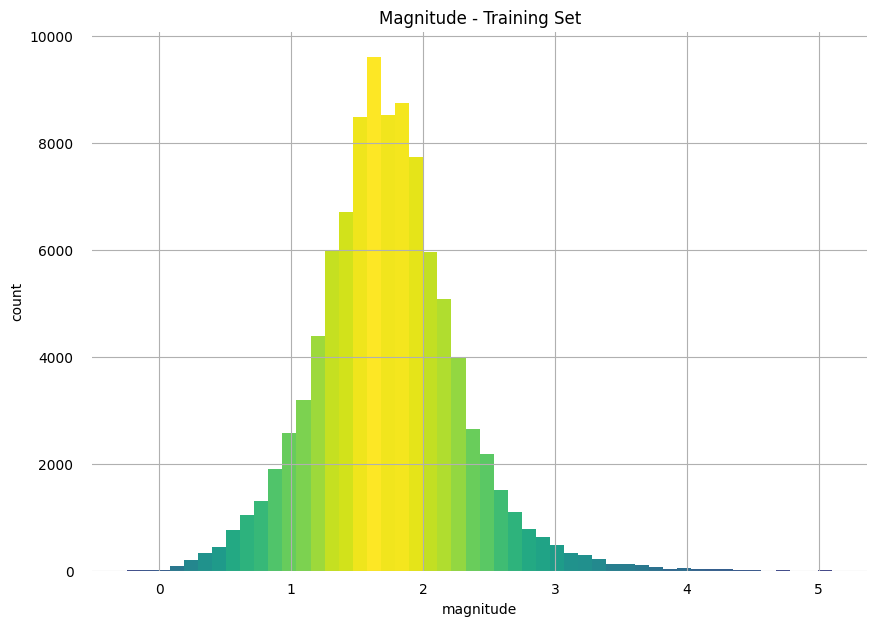

mean magnitude: 1.7239713573588298
standard deviation of magnitude: 0.5324653015609783
q1, q3, interquartile range: 1.4 , 2.03 , 0.6299999999999999


In [ ]:
#First, I'm going to investigate some of the features of the training and testing datasets.
#This is important, since we want to know what the data looks like that UNet is "learning" from,
#and also the features of the data we're testing it on.

#Let's look at the magnitudes of the events UNet was trained on. If there are any
#unusually large magnitudes, we might expect UNet to overestimate its amplitudes
#for higher magnitude events.

#plot histogram of magnitude
magnitude = train["magnitude"]
bins = 50
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(magnitude, bins)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid()

N, bins, patches = ax.hist(magnitude, bins)

# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Adding extra features
plt.xlabel("magnitude")
plt.ylabel("count")
plt.title('Magnitude - Training Set')
plt.show()

mean = statistics.mean(magnitude)
std = statistics.stdev(magnitude)
q3, q1 = np.percentile(magnitude, [75, 25])
iqr = q3 - q1
print("mean magnitude:", mean)
print("standard deviation of magnitude:" , std)
print("q1, q3, interquartile range:", q1, ",", q3, ",", iqr)

External source validation:

According to https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/: Earthquake magnitudes range from a little more than 0 to 8.0 or greater (8.0 and greater being devastating earthquakes). Because this dataset is from the Wasatch Front, Yellowstone, and seismic regions between them, we wouldn't expect the magnitudes to be any larger than about 5.5 or 6. The histogram above is consistent with that expectation, meaning that the training dataset is a good representation of seismic activity for our geographical region (and, perahps, regions with similar geology).

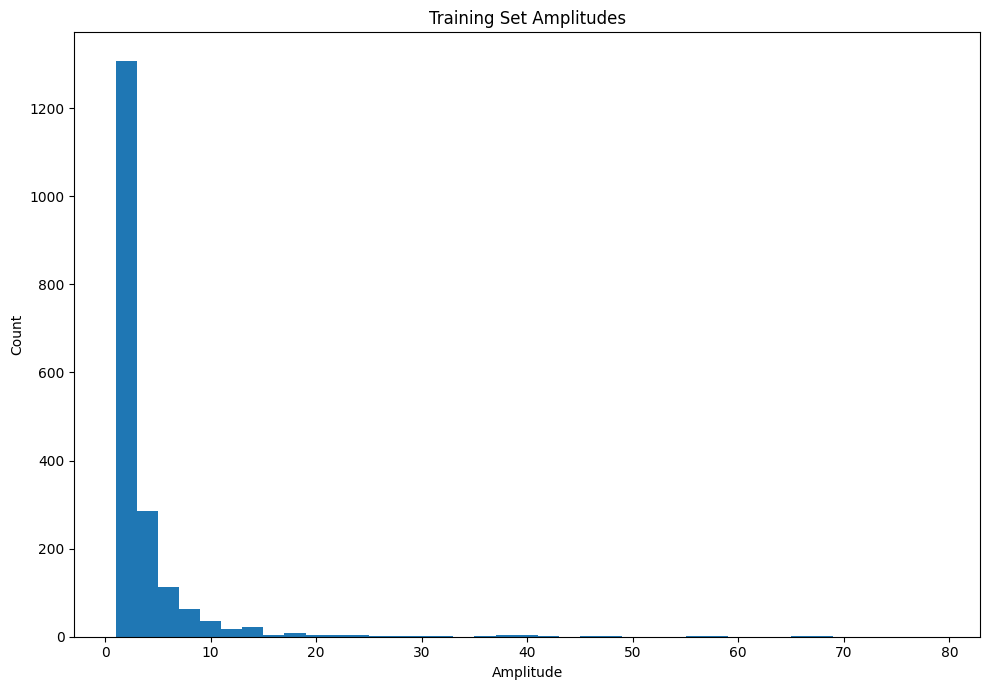

mean amplitude: 0.1561071870848427
standard deviation of amplitude: 2.454110501719103
q1, q3, interquartile range: 0.013037364115025001 , 0.0692342310213 , 0.056196866906275


In [ ]:
#Since the training set magnitudes follow a very typical normal distribution, any
#innacuracies in UNet's estimations will be more likely due to biases in other features.

#Let's look at our star feature: amplitudes!
#Histogram of amplitudes in the training set
amplitude_train = train["amplitude"]
n_bins = 100
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)

bins = np.arange(1, 80, 2)
N, bins, patches = axs.hist(amplitude_train, bins)

# Adding extra features
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title('Training Set Amplitudes')

plt.show()

mean = statistics.mean(amplitude_train)
std = statistics.stdev(amplitude_train)

print("mean amplitude:", mean)
print("standard deviation of amplitude:" , std)

q3, q1 = np.percentile(amplitude_train, [75, 25])
iqr = q3 - q1
print("q1, q3, interquartile range:", q1, ",", q3, ",", iqr)

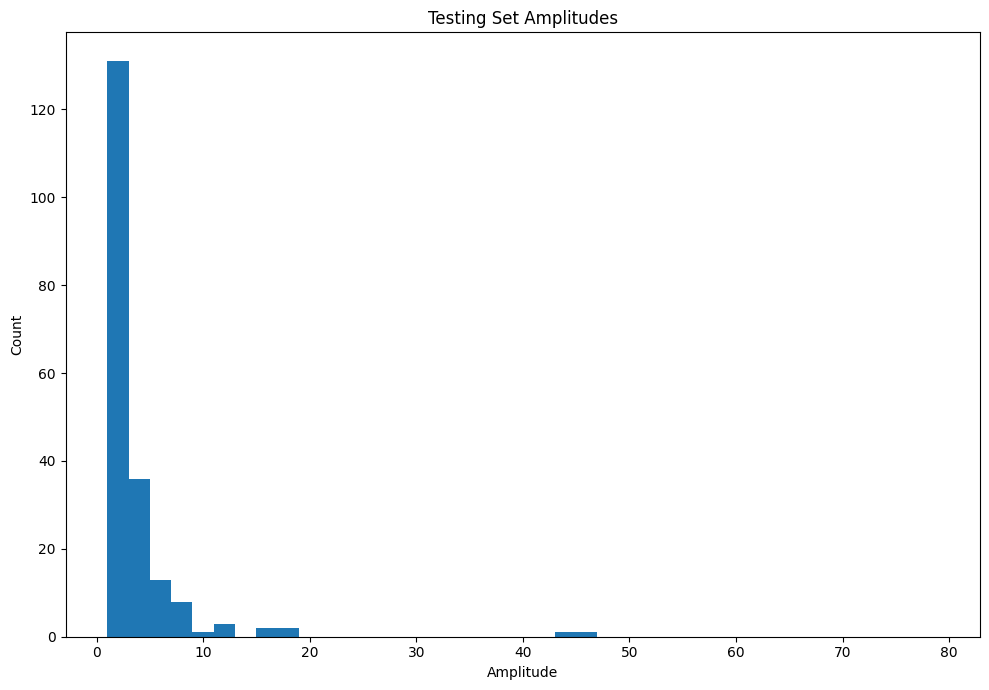

mean amplitude: 0.12652006772324542
standard deviation of amplitude: 0.7958122352092768
q1, q3, interquartile range: 0.01307454903145 , 0.069776274263875 , 0.056701725232425004


In [ ]:
#Histogram of amplitudes in the testing set
amplitude_test = test["amplitude"]
n_bins = 100
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)

bins = np.arange(1, 80, 2)
N, bins, patches = axs.hist(amplitude_test, bins)

# Adding extra features
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title('Testing Set Amplitudes')

plt.show()

mean = statistics.mean(amplitude_test)
std = statistics.stdev(amplitude_test)

print("mean amplitude:", mean)
print("standard deviation of amplitude:" , std)

q3, q1 = np.percentile(amplitude_test, [75, 25])
iqr = q3 - q1
print("q1, q3, interquartile range:", q1, ",", q3, ",", iqr)

Simple Test

Text(0, 0.5, 'Residual')

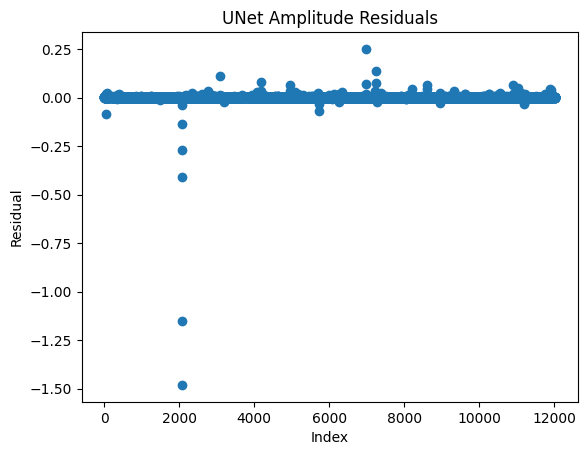

In [ ]:
#Let's see how UNet's residuals are distributed:
xx = np.arange(0, len(amp_resids["difference"]))
plt.scatter(xx, amp_resids["difference"])
plt.title("UNet Amplitude Residuals")
plt.xlabel("Index")
plt.ylabel("Residual")

In [ ]:
#This is a little difficult to interpret. Let's put this on a log scale to better
#see the spread of residuals.

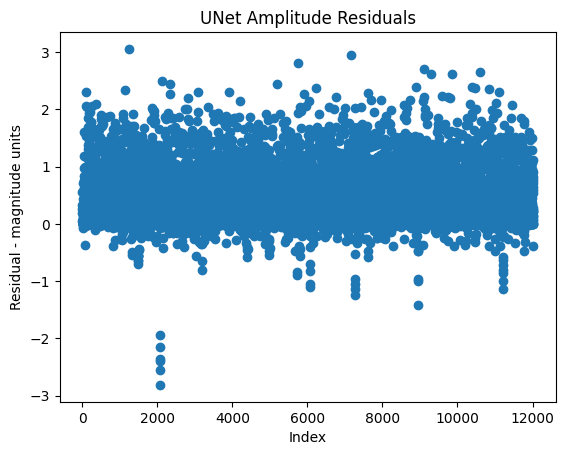

In [ ]:
obsamp = amp_resids["observed_amp"]
unetamp = amp_resids["amplitude"]


plt.scatter(xx, np.log10(obsamp/unetamp))
plt.title("UNet Amplitude Residuals")
plt.xlabel("Index")
plt.ylabel("Residual - magnitude units")
plt.show()

This is a little better. Here, we can see that UNet is at least somewhat consistently underestimating amplitudes, since a lot of these scatter points are between 0 and 3, meaning that UNet's prediction is 0 to 3 amplitude units *below* the observed amplitude.

##Data Cleaning

If you, dear reader, looked at the outputs of the "Creation of Dataframe" section, you may have noticed the pritned statements: "Could not find another window:", followed by some index number. In these two cases, UNet was unable to make a predicition. For further data analysis, these will become inconvenient.

In [ ]:
#Let's see what happens when we simply drop these two points.
clean_resids = amp_resids.dropna()

print(clean_resids.shape)
print(clean_resids["observed_amp"].max())
print(clean_resids["observed_amp"].min())

(12015, 9)
0.4566543197629999
7.72005321778e-06


Great! In the vast volume of our datapoints, we're not missing any super influential points like extrema in observed amplitudes, so we can continue with this new dataframe. Let's just make sure we're not missing any obvious points on our scatterplot:

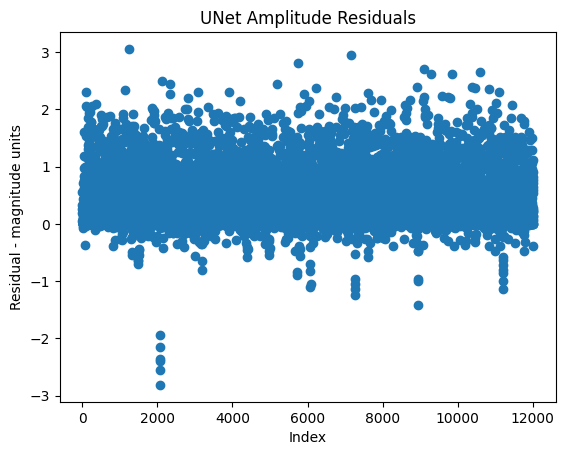

In [ ]:
xx2 = np.arange(0, len(clean_resids["difference"]))
obs2 = clean_resids["observed_amp"]
amp2 = clean_resids["amplitude"]

plt.scatter(xx2, np.log10(obs2/amp2))
plt.title("UNet Amplitude Residuals")
plt.xlabel("Index")
plt.ylabel("Residual - magnitude units")
plt.show()

This is good, but we can't see how many of these points are clustered where. We'll need to introduce density features to really look at UNet's performance.

##Test

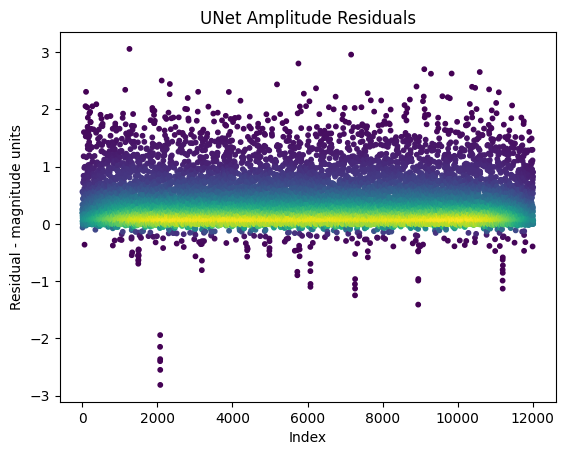

In [ ]:
from scipy.stats import gaussian_kde
# Calculate the point density
x_dens = np.arange(0, len(clean_resids['difference']))
y_dens = np.log10(clean_resids["observed_amp"]/clean_resids["amplitude"])

xy = np.vstack([x_dens, y_dens])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_dens, y_dens, c=z, s=10)
plt.title("UNet Amplitude Residuals")
plt.xlabel("Index")
plt.ylabel("Residual - magnitude units")
plt.show()

In [ ]:
amp_resids["log_10_data"] = np.log10(amp_resids["observed_amp"]/amp_resids["amplitude"])
amp_resids["log_10_data"].describe()

count    12015.000000
mean         0.356287
std          0.427972
min         -2.811850
25%          0.048742
50%          0.229874
75%          0.525912
max          3.052643
Name: log_10_data, dtype: float64

In terms of interpretability, this describe() table is relatively bleak in terms of extracting seismic knowledge for our purposes, except for one important number: the 50% mark for log_10_data, which essentially shows us that UNet is underestimating amplitudes by about 0.23 magnitude units. In terms of magnitudes, this is significant. Earthquakes of between 5.5 and 6.0 can cause slight damage to infrastructure, while a 7.0 can cause serious, deadly damage and is considered a major earthquake.  

I'd also like to see if UNet's underestimations are linearly correlated with the expected amplitude.

                            OLS Regression Results                            
Dep. Variable:               residual   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                 5.594e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:13:37   Log-Likelihood:                 41529.
No. Observations:               12015   AIC:                        -8.305e+04
Df Residuals:                   12013   BIC:                        -8.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0011   6.97

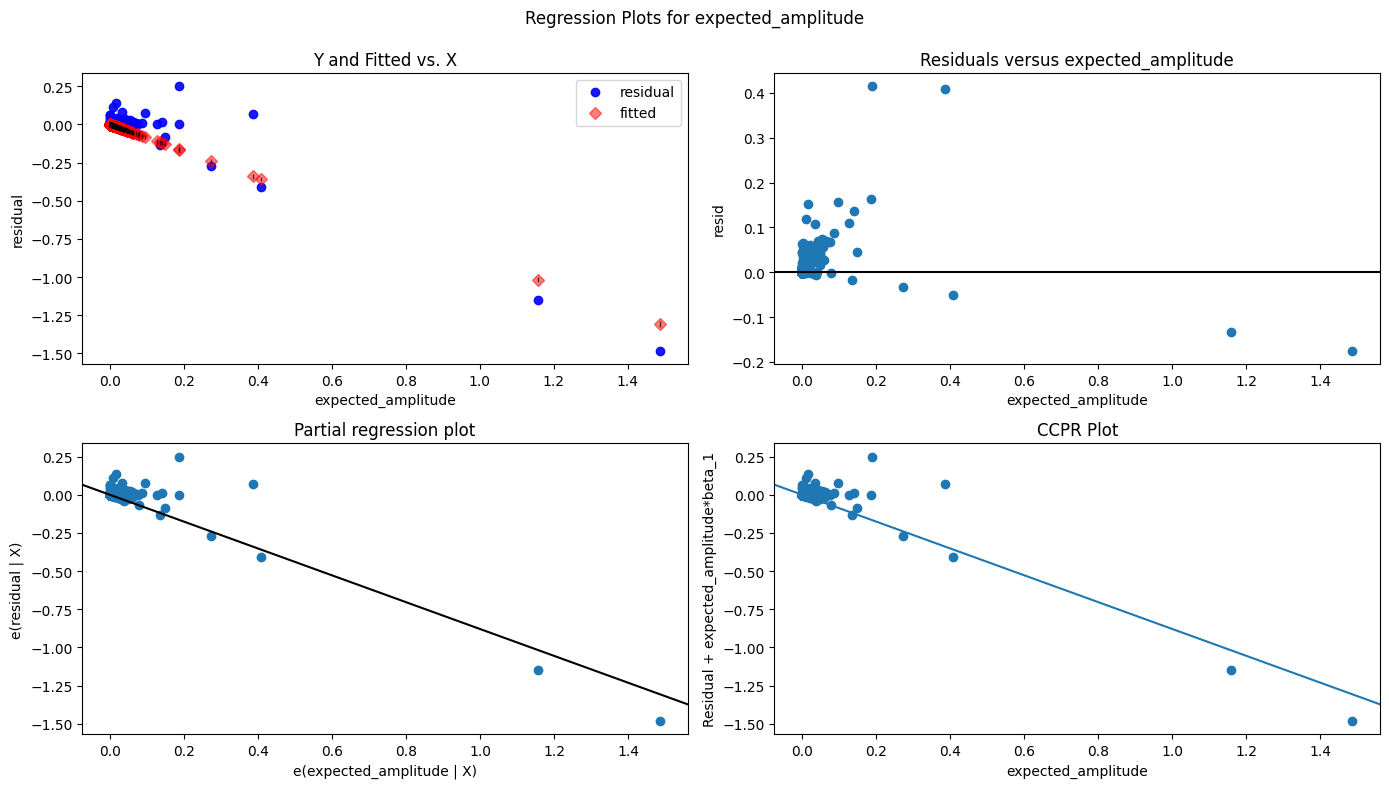

In [ ]:
#linear regression for residuals vs expected amplitude
expected_amplitude = amp_resids["amplitude"]
residual = amp_resids["difference"]
linear_model = ols('residual ~ expected_amplitude',
                   data=amp_resids).fit()

# display model summary
print(linear_model.summary())

# modify figure size
fig = plt.figure(figsize=(14, 8))

# creating regression plots
fig = sm.graphics.plot_regress_exog(linear_model,'expected_amplitude',fig=fig)